In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipympl
import imageio.v3 as iio
import skimage
import skimage.color
import skimage.filters
import skimage.transform
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.draw import circle_perimeter
from skimage.filters.rank import mean
from scipy import ndimage
from scipy.signal import argrelextrema
import math

%matplotlib inline

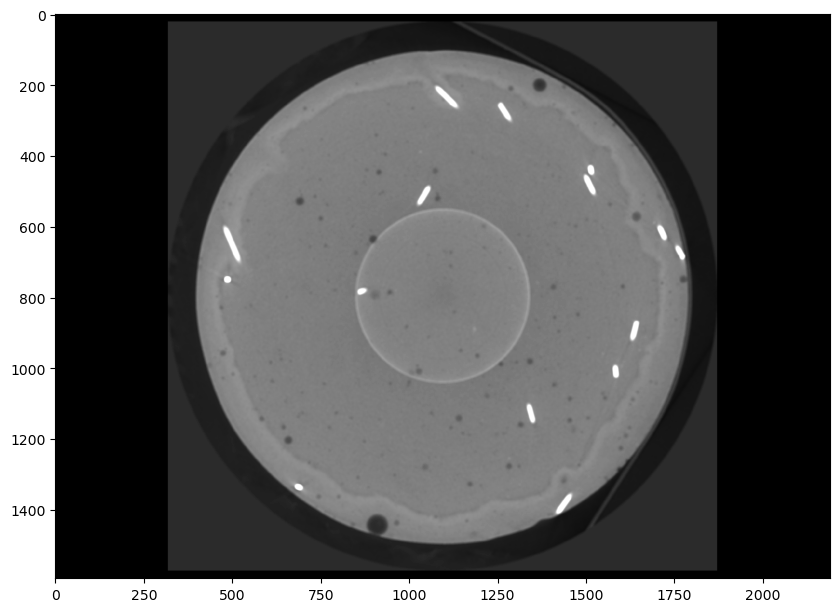

In [2]:
image = iio.imread(uri="data/test.png")
image = skimage.color.rgb2gray(image)

plt.figure(figsize=(10,10))
plt.imshow(image, cmap="gray")
plt.show()


In [3]:
# find the center of the disk by collapssing the image on to x and y axis
vert_sum = np.sum(image, axis=0)
hori_sum = np.sum(image, axis=1)

# Find local min, whihch corresponds to the edges of sample in each direction
xmin = argrelextrema(vert_sum, np.less, order=50)
ymin = argrelextrema(hori_sum, np.less, order=50)
xmin = [xmin[0][0], xmin[0][-1]]
ymin = [ymin[0][0], ymin[0][-1]]

# Find (x,y) coordinate of the center position
x_cen = sum(xmin)/2
y_cen = sum(ymin)/2
center = [x_cen, y_cen]

# Find r by taking the averaged value of r calcualted using horizontal and vertical edge values
x_r = (xmin[1] - xmin[0])/2
y_r = (ymin[1] - ymin[0])/2
radius = (x_r + y_r)/2

print("Center coordinates (x,y):",center)
print("Radius:",radius)

Center coordinates (x,y): [1098.0, 798.0]
Radius: 705.0


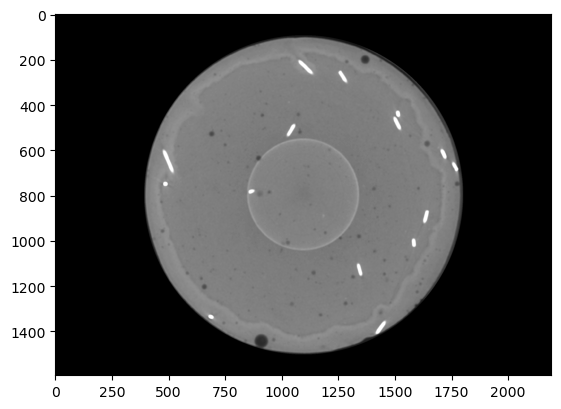

In [4]:
# Define a mask that covers everything but the cylinder to see how well the centering is
mask = np.zeros(shape=image.shape[0:2], dtype="bool")
circle = skimage.draw.disk(center=(center[1], center[0]), radius=radius, shape=image.shape[0:2])
mask[circle] = 1

masked_img = image[:]
masked_img[np.logical_not(mask)] = 0

plt.subplots()
plt.imshow(masked_img, cmap="gray")

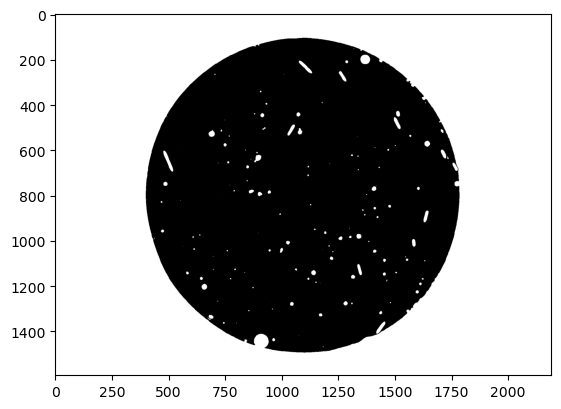

In [5]:
# Define range of pixel values to average over
range = [0.45, 0.95]

# mark pixels outside of the range of interest as 1
marker = np.zeros(shape=image.shape[0:2], dtype="bool")
marker[image < range[0]] = 1
marker[image > range[1]] = 1

plt.imshow(marker, cmap="gray")

C:\Users\Helen Chen\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Helen Chen\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


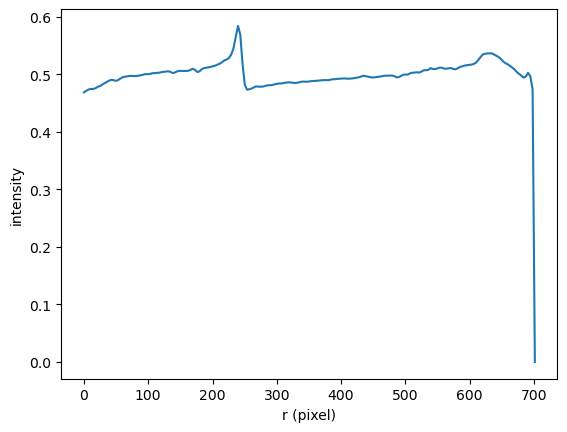

In [8]:
#Define all list radii use for averaging
num = 200
radii = np.linspace(0, radius, num=num+1)

ave_intensity = []
bin_width = radii[1]
for r in radii:
    
    # define a mask that specify the annulus to average over
    if r == radii[-1]:
        break
    r_outer = r + bin_width
    mask = np.zeros(shape=image.shape[0:2], dtype="bool")
    circle_outer = skimage.draw.disk(center=(center[1], center[0]), radius=r_outer, shape=image.shape[0:2])
    mask[circle_outer] = 1
    circle_inner = skimage.draw.disk(center=(center[1], center[0]), radius=r, shape=image.shape[0:2])
    mask[circle_inner] = 0
    # using the marker to reject points on mask that should not be averaged. (i.e. turn them zeros)
    mask[marker == 1] = 0
    
    # average over the slected area
    ave = np.mean(image[mask != 0])

    if math.isnan(ave):
        ave = 0
    ave_intensity.append(ave)
    
# plot the averaged pixel value as a function of r
plt.xlabel("r (pixel)")
plt.ylabel("intensity")
plt.plot(radii[0:-1], ave_intensity)